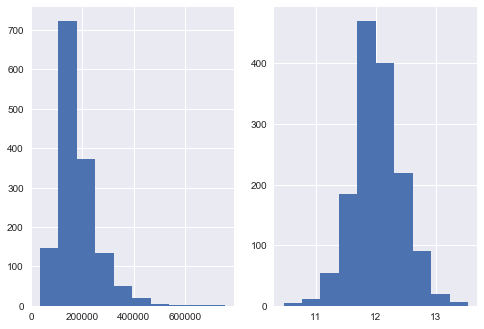

In [86]:


#首先查看分布情况
#查看特征属性
#查看连续特征的分布情况：回归直线
    #删除异常点
#查看离散特征的分布情况：箱线图
    #删除异常点
#查看特征之间的相关性-包括各个特征与标签的相关性
    #特征选择：特征删除，特征组合
#缺失值的填充#需要多观察以及相关知识背景
#独热处理
#归一化  实际GBDT，lightGBM不归一化也是可以的
#模型调参


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np	


train=pd.read_csv('../data/train.csv')
test=pd.read_csv('../data/test.csv')
# print(train.head())


plt.subplot(121)
plt.hist(train.SalePrice)
#房价的分布图
plt.subplot(122)
plt.hist(np.log1p(train.SalePrice))
#对房价进行对数log1p 是log(1+x)防止有0

plt.show()


test=pd.read_csv('../data/test.csv')
features=pd.concat([train,test],keys=['train','test'])	
# print(features.head())


numeric_feats = features.dtypes[features.dtypes!="object"].index
categorical_feats = features.dtypes[features.dtypes=="object"].index

#特征有 数值型和类别特征型

G:\Program Files (x86)\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


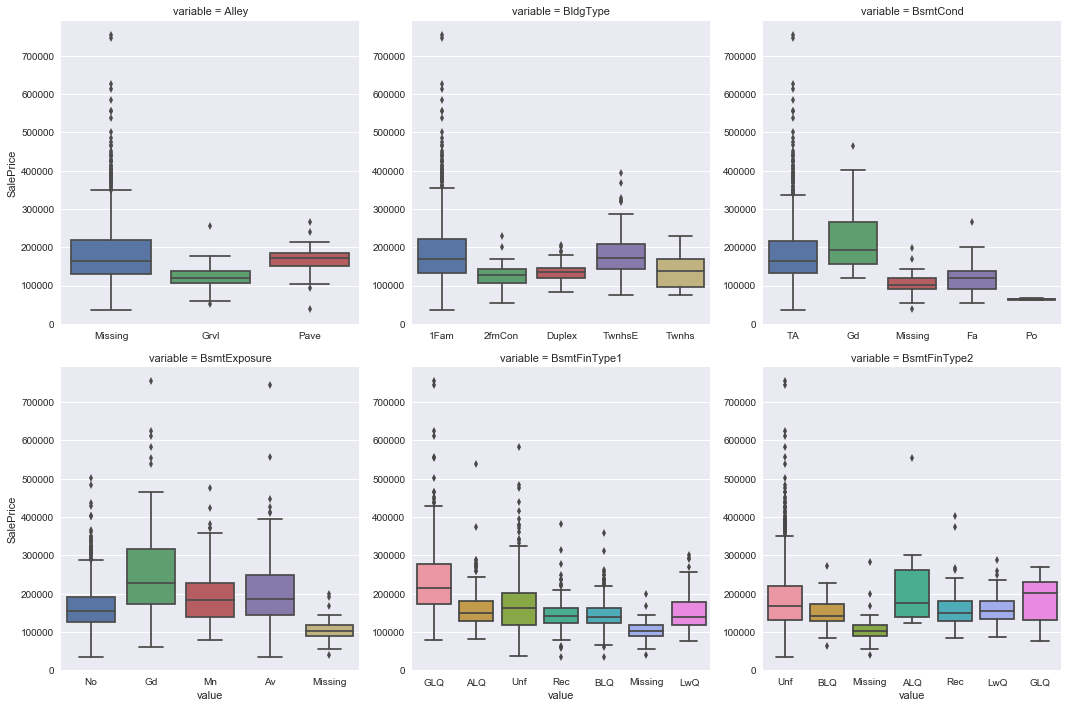

In [87]:
##查看类别特征与房价的关系
import seaborn as sns 
for c in categorical_feats:
    train[c] = train[c].astype('category')#重新定义编码分类
    if train[c].isnull().any():
#         train[c].cat.categories=['o1','o2']###将原有的替换掉
        train[c] = train[c].cat.add_categories(["Missing"])###原有的不变 增加了missing 类别
        train[c] = train[c].fillna("Missing")
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
f = pd.melt(train,id_vars=['SalePrice'],value_vars=categorical_feats[0:6])##只看下前6个
g = sns.FacetGrid(f,col='variable',col_wrap=3,sharex=False,sharey=False,size=5)
g = g.map(boxplot,"value","SalePrice")
# g = g.map(boxplot,"value","SalePrice")
plt.show()


In [88]:
numeric_feats = numeric_feats.drop("SalePrice")

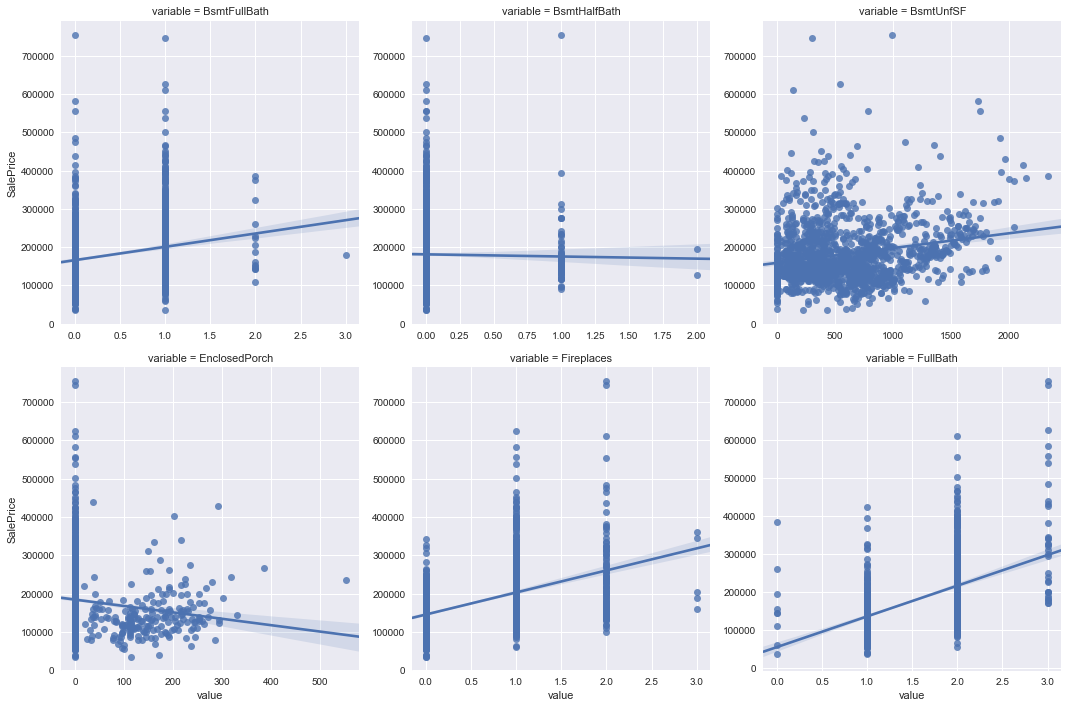

In [89]:

##查看数值型特征与房价的关系
import seaborn as sns 
def jointplot(x,y,**kwargs):
    try:
        sns.regplot(x=x,y=y)
    except Exception:
        print(x.value_counts())

f = pd.melt(train, id_vars=['SalePrice'],value_vars=numeric_feats[6:12])
g = sns.FacetGrid(f,col='variable',col_wrap=3,sharex=False,sharey=False,size=5)
g = g.map(jointplot,"value","SalePrice")
plt.show()




G:\Program Files (x86)\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


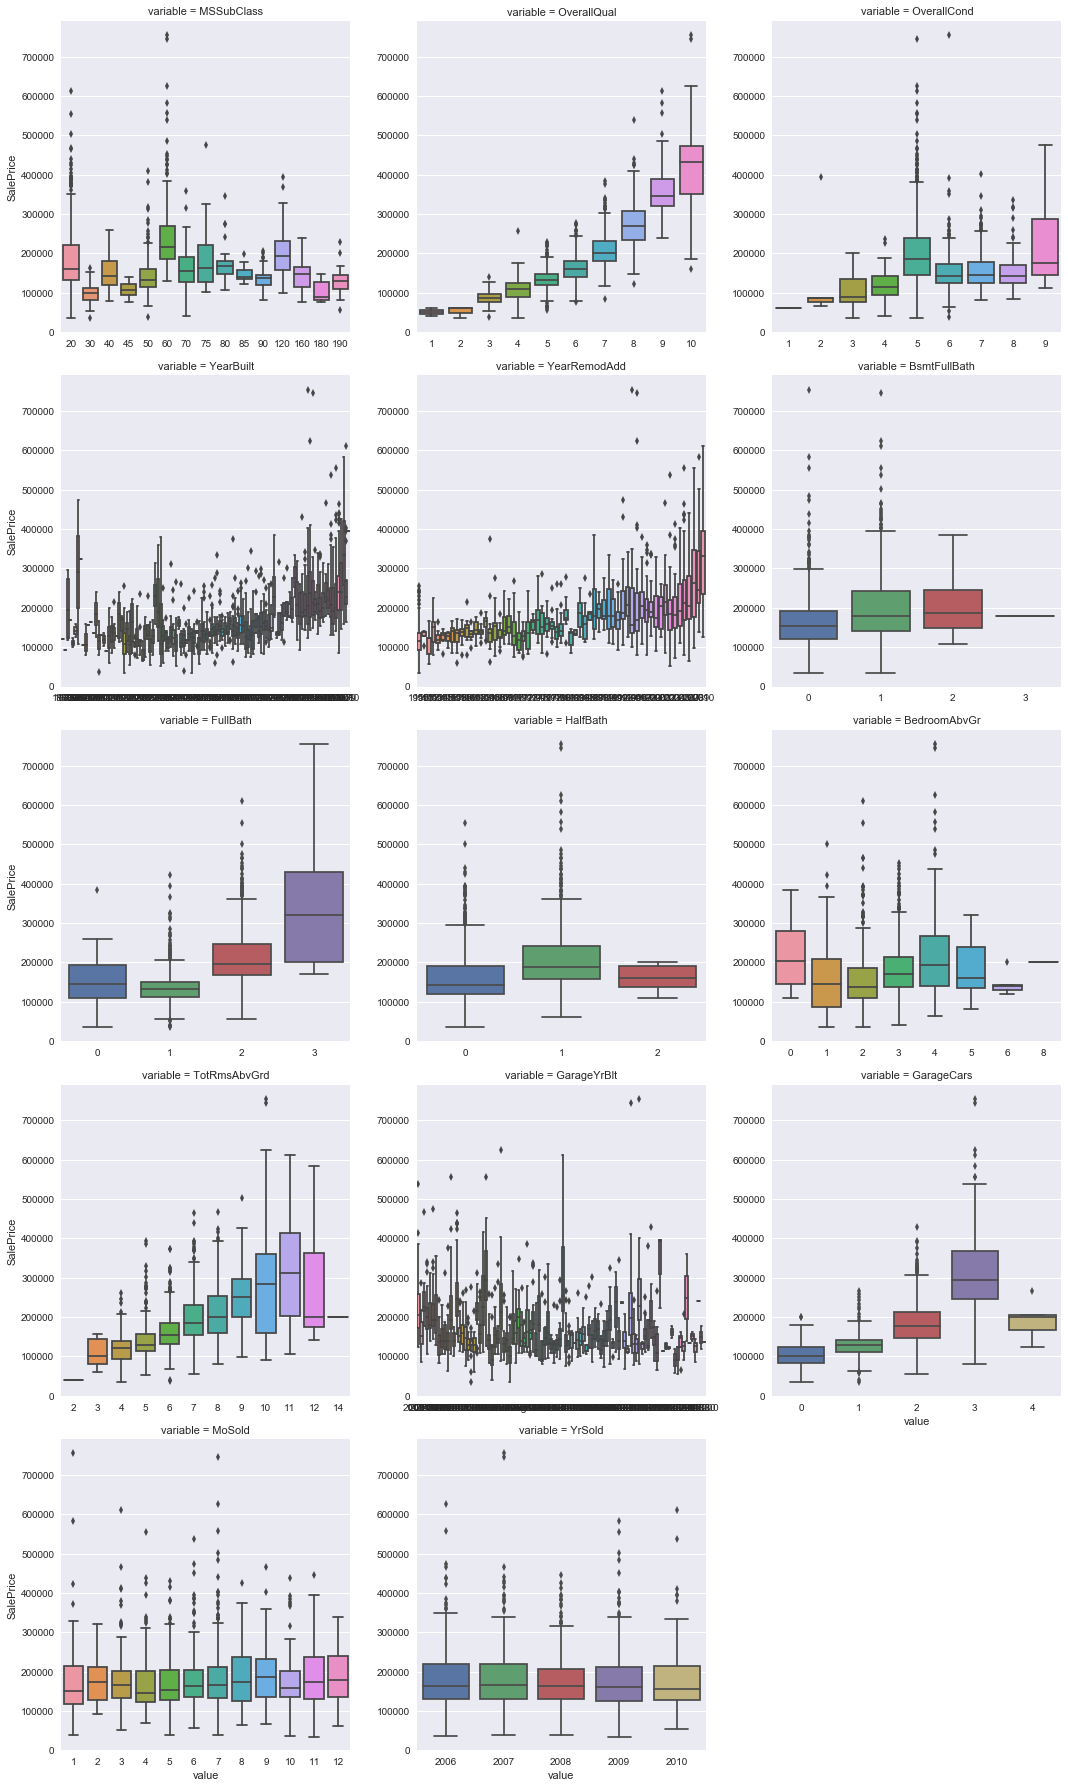

In [90]:
#即使是数字类型的也有可能是离散的
nomial_feats=['MSSubClass','OverallQual','OverallCond','YearBuilt','YearRemodAdd','BsmtFullBath','FullBath','HalfBath',
             'BedroomAbvGr','TotRmsAbvGrd','GarageYrBlt','GarageCars','MoSold','YrSold']
for c in nomial_feats:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(["Missing"])
        train[c] = train[c].fillna("Missing")
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
f = pd.melt(train,id_vars=['SalePrice'],value_vars=nomial_feats)
g = sns.FacetGrid(f,col='variable',col_wrap=3,sharex=False,sharey=False,size=5)
g = g.map(boxplot,"value","SalePrice")
plt.show()

In [91]:
##从数值类第一个图可以看出 有两个非常明显的离群点，GrLivArea 特别大 但是售价特别低
train.drop(train[(train['GrLivArea']>4000)&(train.SalePrice<300000)].index,inplace=True)
features.drop(train[(train['GrLivArea']>4000)&(train.SalePrice<300000)].index,inplace=True)

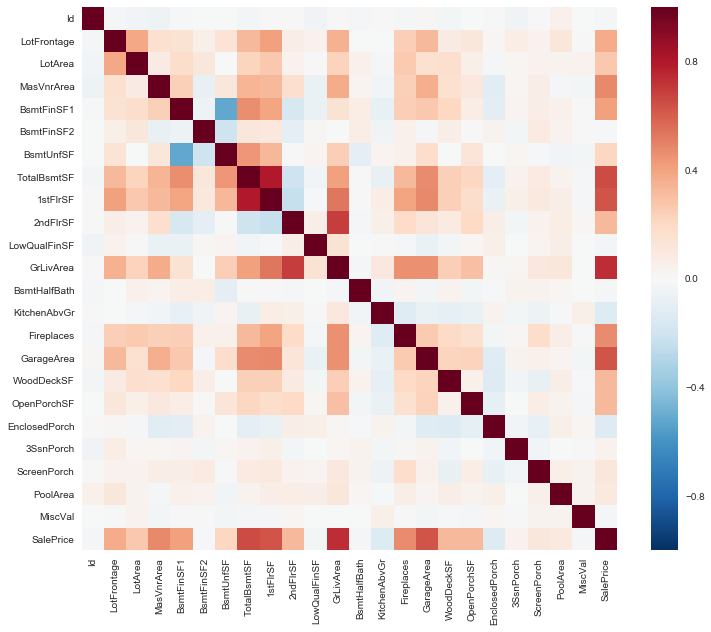

In [92]:
plt.subplots(figsize=(12,10))
corrmat = train.corr()###计算相关性
# plt.pcolor(corrmat)
g = sns.heatmap(corrmat)
plt.show()

In [67]:
#删除几个特征，特征之间相关性高的可以删除
# features.drop(['Id','Street','SaleType','FullBath',
#              '1stFlrSF',],axis=1,inplace=True)
# features.drop(['Id',],axis=1,inplace=True)

In [93]:
features.isnull().sum()[features.isnull().sum()>0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

In [94]:
#缺失值的填充需要大量的分析观察，测试和相关知识背景
#填充空缺值，类别的使用 NA ，数值型的使用0

missing_col_NA = ["Alley","MasVnrType","FireplaceQu","GarageType","PoolQC","Fence",
                  "MiscFeature","GarageQual","GarageCond","GarageFinish"]
missing_col_0 = ["MasVnrArea","GarageCars","GarageArea"]
for col in missing_col_NA:
    features[col].fillna("NA",inplace=True)
    
for col in missing_col_0:
    features[col].fillna(0,inplace=True)

In [95]:
#缺失值的填充需要大量的分析观察，测试和相关知识背景
#缺失数值的使用平均数、众数来代替
missing_col_mode = ["MSZoning","KitchenQual","Functional","SaleType","Electrical","Exterior1st","Exterior2nd"]
for col in missing_col_mode:
    features[col].fillna(features[col].mode()[0],inplace=True)
features['LotFrontage'] = features.groupby("Neighborhood")["LotFrontage"].transform(lambda x:x.fillna(x.median()))


In [96]:
#缺失值的填充需要大量的分析观察，测试和相关知识背景
#由于缺失值的个数是不一样的，所以只有BsmtCond和BsmtQual同时缺失，才将其认为是没有地下室的。
NoBmstIndex = (pd.isnull(features["BsmtCond"])==True)&(pd.isnull(features["BsmtQual"])==True)

features.loc[NoBmstIndex,"BsmtCond"] =features.loc[NoBmstIndex,"BsmtCond"].fillna("NA")
features.loc[NoBmstIndex,"BsmtQual"] =features.loc[NoBmstIndex,"BsmtQual"].fillna("NA")
features.loc[NoBmstIndex,"BsmtExposure"] =features.loc[NoBmstIndex,"BsmtExposure"].fillna("NA")

#其余的用众数来填充
features.BsmtCond.fillna(features.BsmtCond.mode()[0],inplace=True)
features.BsmtQual.fillna(features.BsmtQual.mode()[0],inplace=True)
features.BsmtExposure.fillna(features.BsmtExposure.mode()[0],inplace=True)

features.BsmtFinSF1.fillna(0,inplace=True)
features.BsmtFinSF2.fillna(0,inplace=True)
features.BsmtFinType1.fillna("NA",inplace=True)
features.BsmtFinType2.fillna("NA",inplace=True)

#要将没有地下室和地下室未完成的面积区分开，所以如果是未完成的，将其面积设为中位数
features.loc[features["BsmtFinType1"]=="Unf","BsmtFinSF1"]=features.BsmtFinSF1.median()
features.loc[features["BsmtFinType2"]=="Unf","BsmtFinSF2"]=features.BsmtFinSF1.median()

features.BsmtUnfSF.fillna(0,inplace=True)
features.TotalBsmtSF.fillna(0,inplace=True)

features.BsmtFullBath.fillna(0, inplace=True)
features.BsmtHalfBath.fillna(0, inplace=True)

In [97]:
#缺失值的填充需要大量的分析观察，测试和相关知识背景
features.loc[features["Exterior1st"]==features["Exterior2nd"],"Exterior2nd"]="None"
features.loc[features["Condition1"]==features["Condition2"],"Condition2"]="None"

In [98]:
#Utilities这个特征没有参考价值，可以删掉
features.Utilities.value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [99]:
features.isnull().sum()[features.isnull().sum()>0].sort_values(ascending=False)

SalePrice      1459
GarageYrBlt     159
Utilities         2
dtype: int64

In [100]:
features=features.drop(['GarageYrBlt','Utilities'],axis=1)

In [101]:
#有些数值特征的分布偏度比较大，可以通过对数变化使其变成正态分布
from scipy.special import boxcox1p

numeric_feats = features.dtypes[features.dtypes != "object"].index
# skewed_feats = features[numeric_feats].apply(lambda x: x.skew(x.dropna())) #compute skewness
skewed_feats=features[numeric_feats].dropna()
skewed_feats=skewed_feats.skew()
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

#features[skewed_feats] = np.log1p(features[skewed_feats])
lam=0.15
features[skewed_feats] = boxcox1p(features[skewed_feats],lam)

In [102]:
#将房子分为建完的和未建完的两类
Unf=['2.5Unf','1.5Unf']
features["HouseStypeFinish"]=features["HouseStyle"].map(lambda x:0 if x in Unf else 1)

In [103]:
#数值型转化为类比型
features.YrSold = features.YrSold.astype(str)
features.MoSold = features.MoSold.astype(str)
features.MSSubClass = features.MSSubClass.astype(str)
features.HalfBath = features.HalfBath.astype(str)
features.BedroomAbvGr = features.BedroomAbvGr.astype(str)
features.GarageCars = features.GarageCars.astype(str)

#将数值的改成类别的,当进行独热处理时，选择类型是object或者category的进行处理
nomial_feats=['YrSold','MoSold']
for c in nomial_feats:
    features[c] = features[c].astype('category')
    if features[c].isnull().any():
        features[c] = features[c].cat.add_categories(["NA"])
        features[c] = features[c].fillna("NA")


In [105]:

#将类别型的转换为one-hot,这样才能使用sklearn中的算法进行训练
category_feats = features.dtypes[features.dtypes == "object"].index

for col in category_feats:
    for_dummy = features.pop(col)
    extra_data = pd.get_dummies(for_dummy,prefix=col)
    #print(col,":",extra_data.shape)
    features = pd.concat([features, extra_data],axis=1)

In [106]:
features[:train.shape[0]].head(5)

1stFlrSF   2ndFlrSF  3SsnPorch  BsmtFinSF1  BsmtFinSF2  \
train 0  11.692623  11.686189        0.0   11.170327    9.512744   
      1  12.792276   0.000000        0.0   12.062832    9.512744   
      2  11.892039  11.724598        0.0   10.200343    9.512744   
      3  12.013683  11.354094        0.0    8.274266    9.512744   
      4  12.510588  12.271365        0.0   10.971129    9.512744   

         BsmtFullBath  BsmtHalfBath  BsmtUnfSF  EnclosedPorch  Fireplaces  \
train 0           1.0      0.000000   7.483296       0.000000           0   
      1           0.0      0.730463   8.897844       0.000000           1   
      2           1.0      0.000000   9.917060       0.000000           1   
      3           1.0      0.000000  10.468500       8.797736           1   
      4           1.0      0.000000  10.221051       0.000000           1   

            ...       SaleType_CWD  SaleType_Con  SaleType_ConLD  \
train 0     ...                  0             0               0   
      1     ...                  0             0               0   
      2     ...                  0             0               0   
      3     ...                  0             0               0   
      4     ...                  0             0               0   

         SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  \
train 0               0               0             0             0   
      1               0               0             0             0   
      2               0               0             0             0   
      3               0               0             0             0   
      4               0               0             0             0   

         SaleType_WD  Street_Grvl  Street_Pave  
train 0            1            0            1  
      1            1            0            1  
      2            1            0            1  
      3            1            0            1  
      4            1            0            1  

[5 rows x 333 columns]

In [107]:

#归一化
from sklearn.preprocessing import RobustScaler
N = RobustScaler()

lable=features.pop('SalePrice')
# feature1=features.drop('SalePrice',axis=1)
scale_features = N.fit_transform(features)

In [108]:
from sklearn.utils import shuffle

train_features = scale_features[:train.shape[0]]

test_features = scale_features[train.shape[0]:]
# train_labels = train_features.values[:,-1].copy()

label=lable[:train.shape[0]]
# scale_train_feature=train_features.drop('SalePrice',axis=1)
train_features = N.fit_transform(train_features)


train_features,train_labels = shuffle(train_features,label,random_state=5)

In [109]:
#通过交叉验证获取模型的预测均方误差
from sklearn.model_selection import cross_val_score

def rmse_cv(model,X_train,y):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, 
                                    scoring="neg_mean_squared_error",
                                   cv = 5))
    return rmse

In [110]:
# lightgbm
#pip3 install lightgbm
import lightgbm as lgb 
model_lgb=lgb.LGBMRegressor(objective="regression",n_estimators=1200,
                           learning_rate=0.04,num_leaves=5,feature_fraction=0.25)
lgb_rmse=rmse_cv(model_lgb,train_features,train_labels)
print(lgb_rmse)
print(lgb_rmse.mean(),'    ',lgb_rmse.std())

[0.86803807 0.75764498 0.75635279 0.65049129 0.76888265]
0.7602819571834505      0.06893726625514614


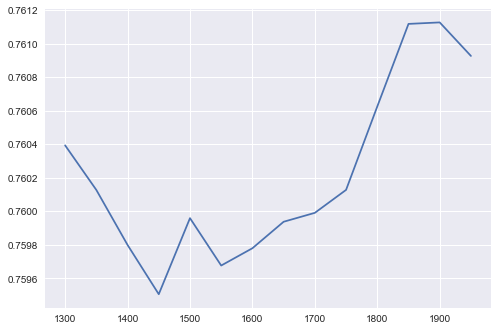

In [114]:
NE=list(range(1300,2000,50))
lgb_cv=[rmse_cv(lgb.LGBMRegressor(objective="regression",n_estimators=ne,
                           learning_rate=0.04,num_leaves=5,feature_fraction=0.25),train_features,train_labels).mean() for ne in NE]

plt.plot(NE,lgb_cv)
plt.show()


In [ ]:
#下面的是一些简单方法

In [ ]:
import lightgbm as lgb

model_lgb=lgb.LGBMClassifier(n_estimatios=30,min_child_samples=20,reg_alpha=0.001,reg_lambda=0.001,
                            learning_rate=0.1,num_leaves=100,feature_fraction=0.75)

[0.080736250155461597, 0.091995311786217351, 0.10764802312125028, 0.11459191830230107]


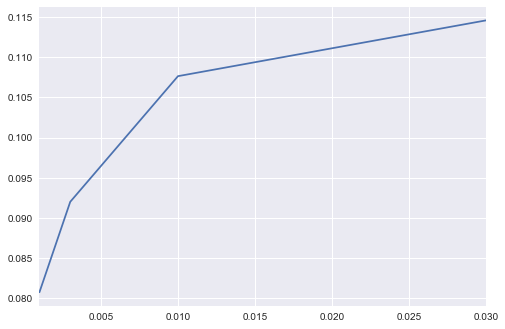

In [57]:
from sklearn.svm import SVR
svm_model=SVR()
Cs=[0.001,0.003,0.01,0.03]
cv_svm=[rmse_cv(SVR(C=c,kernel='linear'),train_features,train_labels).mean() for c in Cs]
print(cv_svm)
cv_svm=pd.Series(cv_svm,index=Cs)
cv_svm.plot()
plt.show()

In [ ]:
#Lasso
from sklearn.linear_model import Lasso
alphas=np.logspace(-5,-3,10)
cv_lasso=[rmse_cv(Lasso(alpha=alpha),train_features,train_labels).mean() for alpha in alphas]
print(cv_lasso)
cv_lasso=pd.Series(cv_lasso,inde
                   x=alphas)
cv_lasso.plot()
plt.show()

G:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
G:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
G:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
G:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not co

[0.87801095849410715, 0.86295796074649012, 0.84464099437462747, 0.82560513205208719, 0.80758812176298922, 0.79340131571690153, 0.78443581226397008, 0.77905855821953041, 0.7790229679146462, 0.78473761755458582]


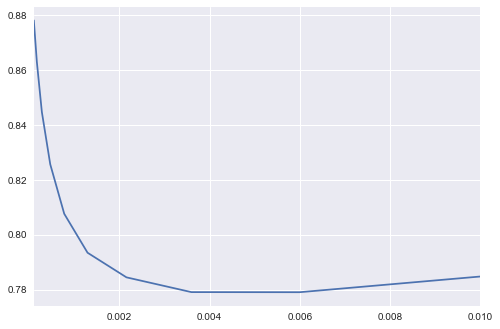

In [55]:
#弹性网络，L1和L2正则化得混合

from sklearn.linear_model import ElasticNet
alphas=np.logspace(-4,-2,10)
cv_lasso=[rmse_cv(ElasticNet(alpha=alpha),train_features,train_labels).mean() for alpha in alphas]
print(cv_lasso)
cv_lasso=pd.Series(cv_lasso,index=alphas)
cv_lasso.plot()
plt.show()